# README

#Setup

In [28]:
import numpy as np
import pandas as pd
import math
import itertools
import random
import torch
import os
import gzip
import json
from tqdm import tqdm
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import AutoModelForMaskedLM, DataCollatorForWholeWordMask, DataCollatorForLanguageModeling, pipeline
from transformers import AdamW, get_linear_schedule_with_warmup, TrainerCallback
from sklearn.model_selection import StratifiedKFold
import shutil
from datasets import load_metric
import gc
gc.enable()
from sklearn.svm import SVR, LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso, BayesianRidge, Perceptron, SGDRegressor

# Constants

In [29]:
BASE_PATH = '/home/masa1357/Dockerdata/gitfile/kaggle_clrp_1st_place_solution'

In [30]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 28
seed_everything(seed=SEED)
MAX_LENGTH = 256

In [31]:
# fine-tuned model paths
# adjust path if you have saved the models in different directories
ALBERT_TRAINED_1 = os.path.join(BASE_PATH, 'models/albert-xxlarge-2-models')#OK
ALBERT_TRAINED_2 = os.path.join(BASE_PATH, 'models/albert-xxlarge-low-lr')#OK
ALBERT_TRAINED_3 = os.path.join(BASE_PATH, 'models/ALBERT_3/albert-xxlarge-all-data')#OK
DEBERTA_TRAINED_1 = os.path.join(BASE_PATH, 'models/deberta-large')#OK
DEBERTA_TRAINED_2 = os.path.join(BASE_PATH, 'models/deberta-large-low-lr')#OK
DEBERTA_TRAINED_3 = os.path.join(BASE_PATH, 'models/deberta-augmented-continued')#OK
ROBERTA_TRAINED_1 = os.path.join(BASE_PATH, 'models/roberta-large-two-models')#OK
ELECTRA_TRAINED_1 = os.path.join(BASE_PATH, 'models/electra-large')#OK

In [32]:
# ensemble model paths
RIDGE_ENSEMBLE_1 = os.path.join(BASE_PATH, 'models/electra-larger-ensemble')
RIDGE_ENSEMBLE_2 = os.path.join(BASE_PATH, 'models/huge-ensemble')

# Functions

In [33]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [34]:
def predict_fast(model_name=None, data=None, init_model=None, tokenizer=None, num_labels=1, is_multilabel=False, output_logits=False, use_softmax=False):
  device = "cuda:0"
  tokenizer = AutoTokenizer.from_pretrained(model_name) if model_name else tokenizer
  config = AutoConfig.from_pretrained(model_name, num_labels=num_labels) if model_name else None
  model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config) if model_name else init_model
  model.to(device)
  model.eval()
  y_pred = []
  batches = chunks(data, 32)
  for batch in tqdm(batches):
    inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LENGTH)
    input_ids = inputs['input_ids'].to(device)
    attention = inputs['attention_mask'].to(device)
    inputs = {
        'input_ids': input_ids,
        'attention_mask': attention
    }
    with torch.no_grad():        
          outputs = model(**inputs)
    if not use_softmax:
      logits = outputs[0].detach().cpu().numpy().squeeze().tolist()
    else:
      logits = nn.functional.softmax(outputs.logits, dim=-1).detach().cpu().numpy().squeeze().tolist()
    if is_multilabel and not output_logits:
      logits = np.argmax(logits, axis=-1)
    y_pred.extend(logits)
  del model
  gc.collect()
  return y_pred

In [35]:
def rms(y_actual, y_predicted):
  return mean_squared_error(y_actual, y_predicted, squared=False)

In [36]:
from joblib import load

In [37]:
def make_ensembler_predictions(fold_predictions, ensembler_dirs, return_mean=True):
  final_predictions = []
  for idx, predictions in enumerate(fold_predictions):
    #print(f"Length of predictions for fold {idx}: {len(predictions)}")  # Change this line
    clf = load(ensembler_dirs[idx])
    n_features = clf.coef_.shape[-1]  # The number of features used by the model
    #print(f"The model was trained with {n_features} features.")
    Y = np.column_stack(predictions)
    y_preds = clf.predict(Y)
    final_predictions.append(y_preds)
  
  if return_mean:
    preds = np.vstack(final_predictions)
    del final_predictions
    return np.mean(preds, axis=0)
  else:
    return final_predictions

# Load test data

In [38]:
# You will need to place the test data in /data/test/test.csv
test_df = pd.read_csv('/home/masa1357/Dockerdata/gitfile/kaggle_clrp_1st_place_solution/CourceFormat/cource1.csv')
test_df.rename(columns={'1': 'excerpt'}, inplace=True)
#test_df = pd.read_csv(os.path.join(BASE_PATH, 'data/training/original/train.csv'))
test_tx = [str(t) for t in test_df.excerpt.values]


# Prediction

In [56]:
# Getting transformer predictions

model_dirs = [
    ALBERT_TRAINED_1,
    DEBERTA_TRAINED_1,
    ALBERT_TRAINED_2,
    DEBERTA_TRAINED_2,
    ROBERTA_TRAINED_1,
    ELECTRA_TRAINED_1
]

for i in range(1):
    model = model_dirs[4]
    preds = predict_fast(model_name=os.path.join(model, 'model_fold_' + str(i) + '/best'), data=test_tx)
    RoBERTa_preds.append(np.array(preds))


19it [00:04,  4.55it/s]


In [76]:
RoBERTa = np.array(RoBERTa_preds)
RoBERTa.shape

(3, 603)

In [74]:
answer = test_df.target.values
answer.shape

(603,)

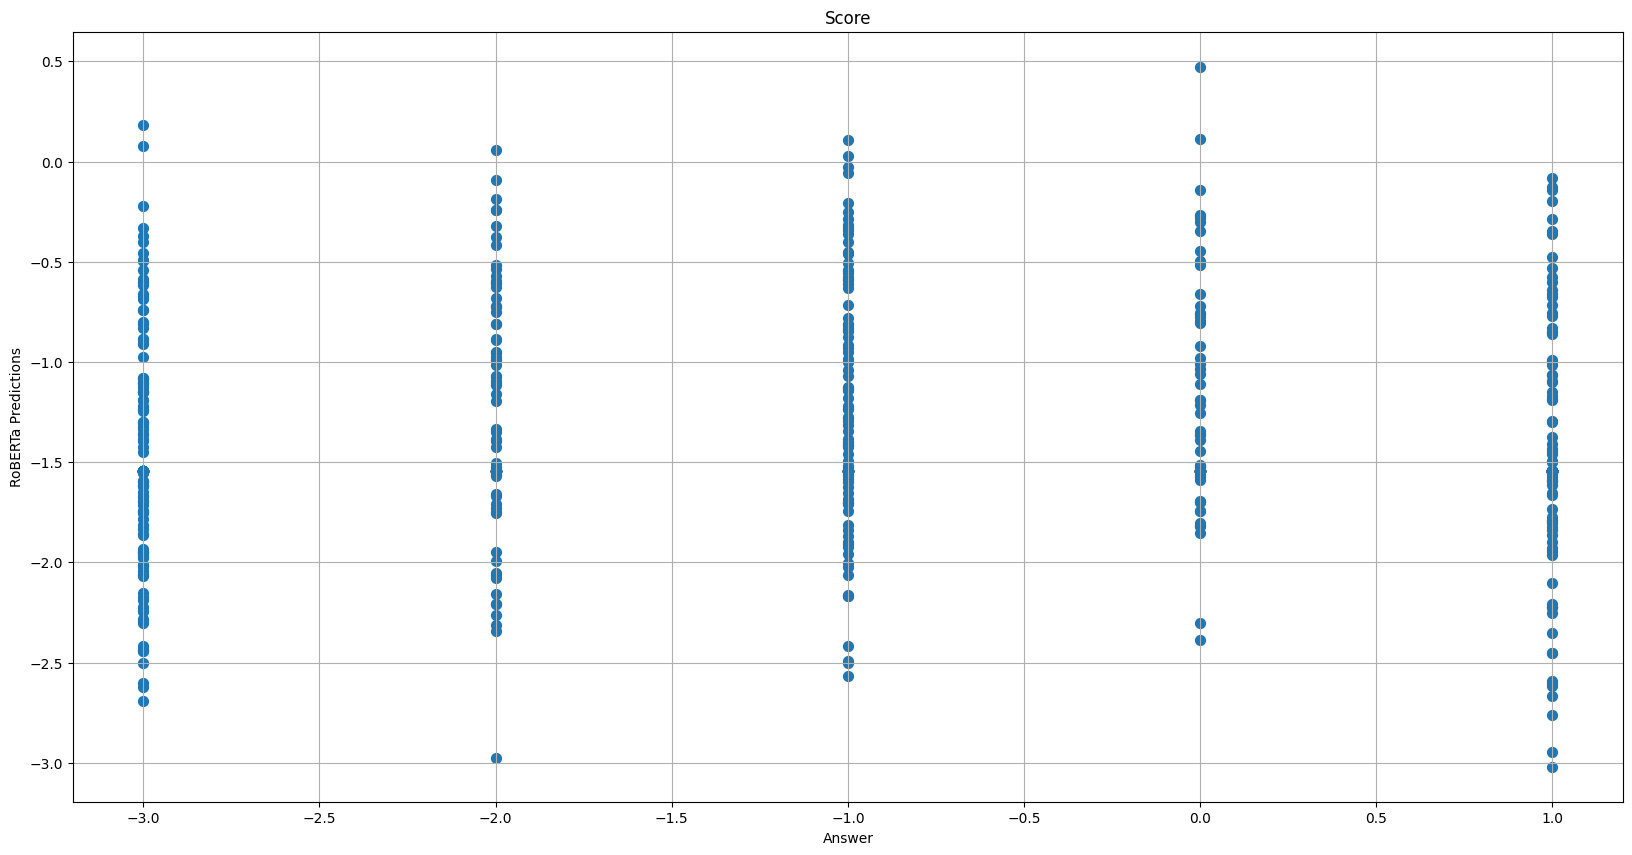

In [85]:
plt.figure(figsize=(20, 10))
plt.scatter(answer, RoBERTa_preds[0], s=50)
plt.title("Score")
plt.xlabel("Answer")
plt.ylabel("RoBERTa Predictions")
plt.grid(True)
plt.show()
